In [7]:
import os
import cv2
import numpy as np
import pandas as pd

# ingnore warning
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


from tensorflow.keras.models import load_model
import tensorflow as tf

1. 2_15클래스 내에서 5개로 군집화한 데이터들 군집별 데이터 샘플링
2. 이미지로부터 데이터 역추적하여 찜콩앱에서 어떤 상품 추천하는지 확인(군집별 데이터 샘플링할 때 검색되는 상품 조건으로 잡기)
3. 단순 전이학습에서 추출한 피처로 추천하는 상품과 코사인 유사도 제시
4. 전이학습 및 미세조정한 분류모델에서 추출한 피처 + 군집화 내에서 유사한 상품이미지 추천

# 1. 2_15(의류-상의)클래스의 5개 군집화된 데이터 샘플링

In [3]:
%%time
df = pd.read_csv('./data/clustering2.csv', encoding='utf-8', index_col=0)

CPU times: user 24.6 s, sys: 1.5 s, total: 26.1 s
Wall time: 26.1 s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51260 entries, 0 to 51259
Columns: 2051 entries, filename to center_distance
dtypes: float64(2049), int64(1), object(1)
memory usage: 802.5+ MB


In [5]:
df['cluster'].value_counts()

3    12155
2    11752
4     9528
0     9489
1     8336
Name: cluster, dtype: int64

In [8]:
# 1000개 샘플링

from sklearn.model_selection import train_test_split

X = []
y = []

path = './data/2_15_crop'

for i in range(5):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 1000, replace=False)
    for file in tqdm_notebook(random_set):
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        X.append(dst)
        y.append(df[df['filename'] == file]['cluster'].values[0]) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
df.head()

,filename,0,1,2,3,4,5,6,7,8,...,2040,2041,2042,2043,2044,2045,2046,2047,cluster,center_distance
0,0.jpg,0.538921,0.277842,0.211032,0.688597,0.185452,0.011790,0.730540,1.207996,0.353460,...,0.161039,0.020428,0.108557,0.375065,0.752277,0.228633,0.100316,0.238573,0,12.912765
1,1.jpg,0.034592,0.369639,0.285800,0.384725,0.161416,0.087499,0.072539,0.054384,0.099075,...,0.417268,0.411512,0.309312,0.799908,0.390913,0.036137,0.323454,0.408953,4,11.271339
2,10.jpg,0.327455,0.172024,0.471271,0.691185,0.073252,0.192843,0.303251,0.252891,0.429027,...,0.111094,0.906809,0.254723,1.594207,1.123552,0.449776,0.011376,0.476048,0,14.281709
3,100.jpg,0.455779,0.937296,1.336042,0.189010,0.308206,0.088695,0.333553,0.254512,0.093298,...,0.881172,1.004324,0.065228,0.354559,0.178113,0.522083,0.709399,0.235006,0,10.513697
4,1000.jpeg,0.158576,0.593128,0.319609,0.634666,0.258412,0.307201,0.383449,1.362908,0.106569,...,0.323253,1.327696,0.239198,0.122088,1.716506,0.229803,1.230238,0.292252,2,14.737880


In [14]:
df0 = df[df['cluster'] == 0].sample(1000)
df1 = df[df['cluster'] == 1].sample(1000)
df2 = df[df['cluster'] == 2].sample(1000)
df3 = df[df['cluster'] == 3].sample(1000)
df4 = df[df['cluster'] == 4].sample(1000)

In [18]:
df00 = df0.sample(5)
df11 = df1.sample(5)
df22 = df2.sample(5)
df33 = df3.sample(5)
df44 = df4.sample(5)

In [26]:
df00[['filename', 'cluster']]

,filename,cluster
16123,28863.jpg,0
12291,24607.jpg,0
33714,47080.jpg,0
31767,45180.jpg,0
2593,13350.jpg,0


# 1. 기존 추천 방식 찾기

In [20]:
raw_df = pd.read_csv('./data/zzimcong.csv', encoding='utf-8', index_col=0)

In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405150 entries, 2926 to 4213459
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   name                  404903 non-null  object 
 1   brand_id              405150 non-null  int64  
 2   brand_name            405150 non-null  object 
 3   parent_category_id    390674 non-null  float64
 4   parent_category_name  390674 non-null  object 
 5   category_id           390674 non-null  float64
 6   category_id.1         390674 non-null  object 
 7   price                 405150 non-null  int64  
 8   image_url             405150 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 30.9+ MB


In [25]:
raw_df.head()

,name,brand_id,brand_name,parent_category_id,parent_category_name,category_id,category_id.1,price,image_url
id,,,,,,,,,
2926,사슴 배냇저고리 세트_Cotton,5,호호당,2.0,의류,25.0,신생아의류,42000,https://hohodangstore.co.kr/web/product/medium...
2929,아이 백일 선물 세트,5,호호당,1.0,용품,27.0,기타용품,92000,https://hohodangstore.co.kr/web/product/medium...
2930,[카드] 연하장 : New year 2021,5,호호당,1.0,용품,27.0,기타용품,2500,https://hohodangstore.co.kr/web/product/medium...
2931,[카드] 일상 : Thanks and love,5,호호당,1.0,용품,27.0,기타용품,2500,https://hohodangstore.co.kr/web/product/medium...
2932,금줄,5,호호당,1.0,용품,27.0,기타용품,35000,https://hohodangstore.co.kr/web/product/medium...


- 파일 이름이 image_url과 매핑이 안되서 역추적이 어렵다
- 그러므로 샘플링된 데이터를 기반으로 비슷한 이미지 찾아서 뭘 추천해주는지 보는 방법 존재

# 2. 단순 전이학습 유사도 추천(Inception v3)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
from keras.applications.inception_v3 import preprocess_input

In [40]:
from tensorflow.keras.applications.inception_v3  import InceptionV3 , preprocess_input

inception_v3_base = InceptionV3 (weights='imagenet', include_top=True)
inception_v3_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [41]:
from tensorflow.keras.models import Model
inception_v3_model = Model(inputs=inception_v3_base.input, outputs=inception_v3_base.get_layer('avg_pool').output)

In [33]:
path = './data/2_15_crop'
os.listdir(path)[:5]

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpeg']

In [44]:
# Load 51260개 샘플데이터 (5개 군집화 섞인 이미지 데이터)
load_2_15 = np.load('./data/2_15_sample.npy')
len(load_2_15)

51260

In [45]:
%%time

# calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(load_2_15, load_2_15)

In [49]:
tuning_result = pd.DataFrame(cosine_sim, columns=os.listdir(path), index=os.listdir(path))
tuning_result.tail()

,0.jpg,1.jpg,10.jpg,100.jpg,1000.jpeg,10000.jpg,10001.jpg,10002.jpg,10003.jpg,10004.jpg,...,9990.jpg,9991.jpg,9992.jpg,9993.jpg,9994.jpg,9995.jpg,9996.jpg,9997.jpg,9998.jpg,9999.jpg
9995.jpg,0.882424,4.764739e-03,2.286136e-04,9.792222e-05,1.444393e-05,2.173706e-01,0.014458,0.006356,0.004934,0.006384,...,9.332690e-05,0.975515,0.999814,9.760708e-01,0.976541,1.000000,0.223517,0.968850,9.760526e-01,2.173706e-01
9996.jpg,0.006409,3.858261e-05,2.157061e-06,8.918079e-07,2.276180e-07,9.999802e-01,0.024732,0.000573,0.000055,0.000664,...,7.805689e-07,0.006758,0.241411,6.301707e-03,0.008477,0.223517,1.000000,0.008359,6.301301e-03,9.999802e-01
9997.jpg,0.902205,9.249169e-02,1.673780e-02,1.463007e-02,2.184239e-03,2.105674e-03,0.133725,0.130821,0.078240,0.130830,...,4.599500e-03,0.994681,0.964026,9.913428e-01,0.991326,0.968850,0.008359,1.000000,9.912981e-01,2.105593e-03
9998.jpg,0.903969,4.726097e-03,2.637045e-03,4.519612e-04,5.835420e-03,5.980704e-08,0.002942,0.000038,0.006193,0.000050,...,5.869348e-03,0.999265,0.971908,9.999846e-01,0.999981,0.976053,0.006301,0.991298,9.999999e-01,4.206786e-08
9999.jpg,0.000713,9.332242e-07,2.059959e-07,2.515760e-09,6.225077e-10,1.000000e+00,0.024663,0.000522,0.000017,0.000614,...,1.025604e-09,0.000460,0.235291,3.296308e-07,0.002176,0.217371,0.999980,0.002106,4.206786e-08,1.000000e+00


In [51]:
# random sampleing
random_samples = np.random.choice(os.listdir(path), 10)
random_samples

array(['57033.jpg', '58835.jpg', '32162.jpg', '30900.jpg', '18367.jpg',
       '13891.jpg', '55348.jpg', '48112.jpg', '18932.jpg', '5594.jpg'],
      dtype='<U10')

In [53]:
def show_sim_image(item):
    origin_path = path + '/' + item
    plt.figure(figsize=(30, 30))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 11, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(tuning_result[item].sort_values(ascending=False)[1:11].index, tuning_result[item].sort_values(ascending=False)[1:11].values))

    for j, values in enumerate(sim_list):
        sim_path = path + '/' + values[0]
        plt.subplot(1, 11, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()

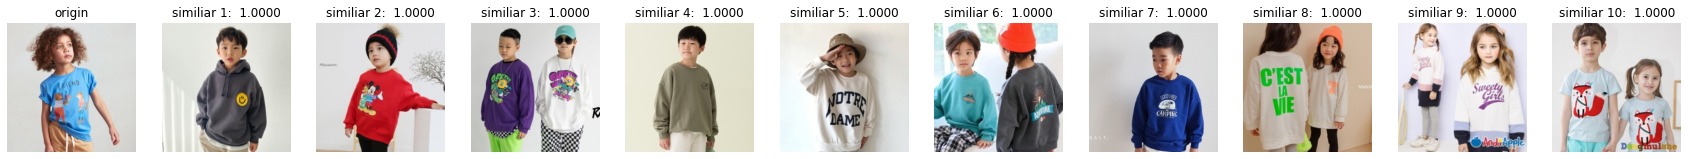

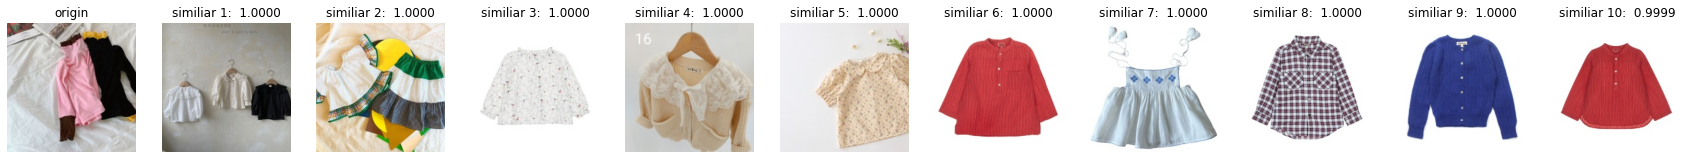

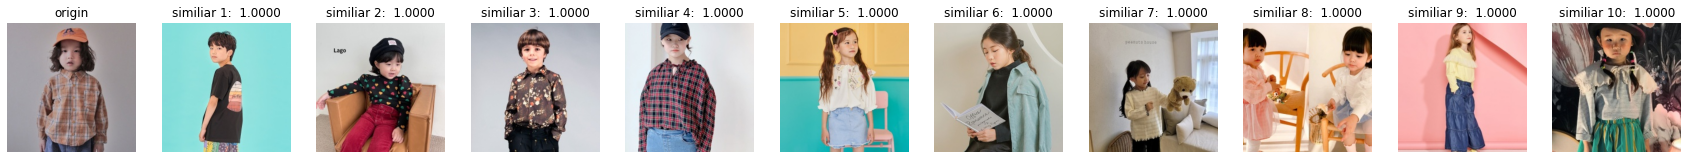

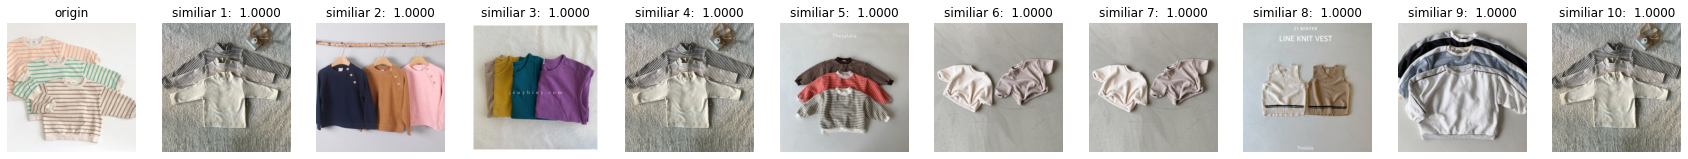

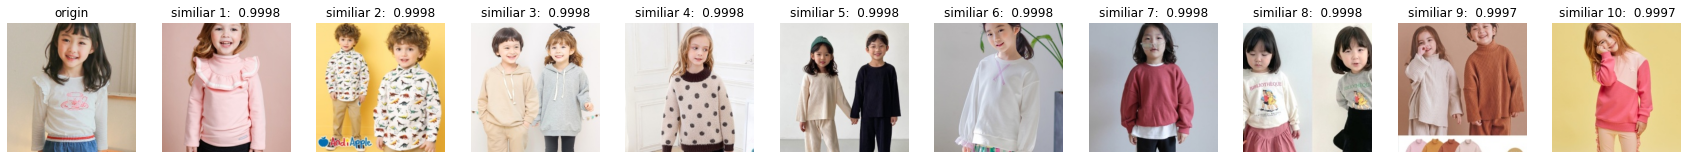

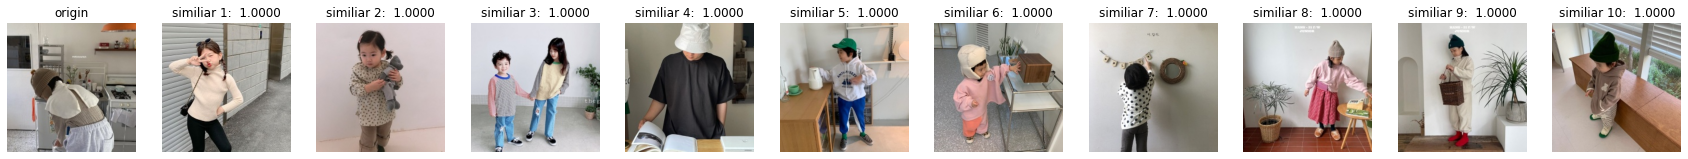

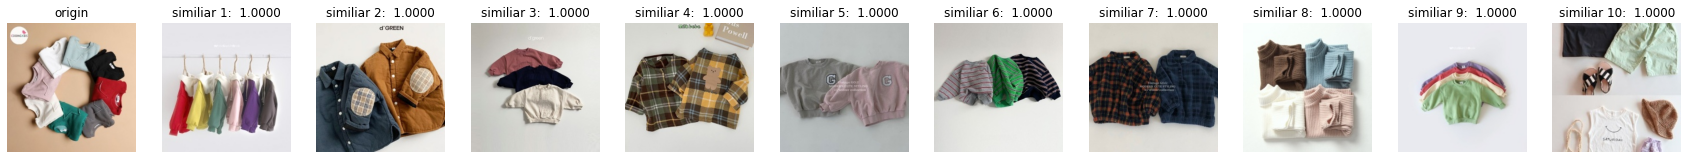

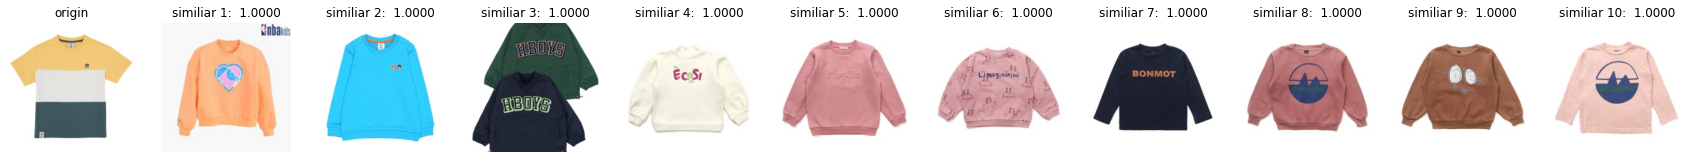

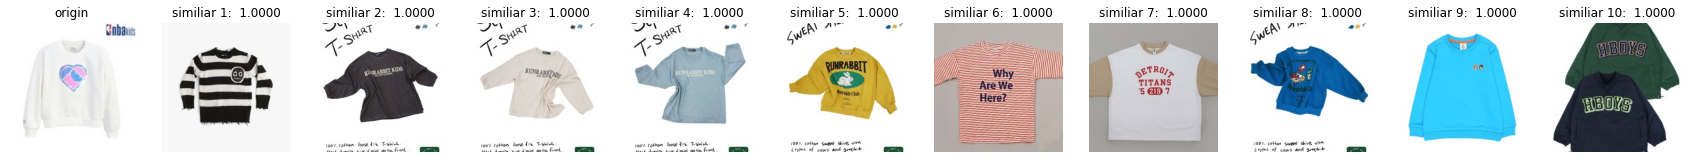

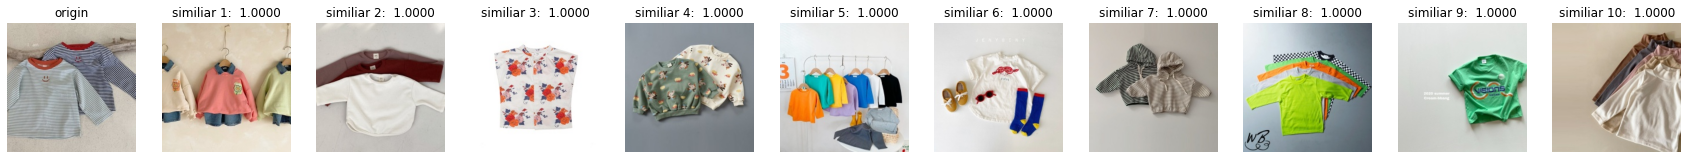

In [54]:
# random sampleing
random_samples = np.random.choice(os.listdir(path), 10)
random_samples

for filename in random_samples:
    show_sim_image(filename)
    print('\n')

- InceptionV3로 유사한 상품 추천 구현한 코드 생성